# **Autoencoders for Denoising and Colorization of Images**

Team Members:  
* Aayush Rajesh (200070001)  
* Kunal Randad (20D070049)  
* Ronil Mandavia (20D180020)

In [ ]:
# Importing necessary libraries
import keras
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers.convolutional import UpSampling2D
from torchvision import datasets, models
import os

## **Additive Noise Image Denoising**

Here we are working with the MNIST dataset which we shall import from keras

In [ ]:
# importing dataset
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# our training data contains 60000 28x28 images
print(X_train.shape)

(60000, 28, 28)


In [ ]:
# plotting the MNIST dataset
def plot_mnist(image, location):
  plt.subplot(221 + location)
  plt.imshow(image, cmap=plt.get_cmap('gray'))

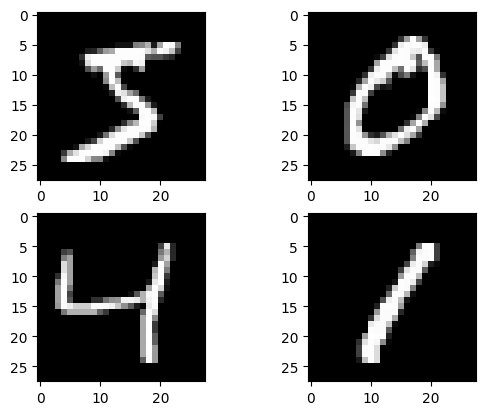

In [ ]:
for i in range(4):
  plot_mnist(X_train[i], i)
plt.show()  

Above are some of the sample images from the training dataset 

In [ ]:
def pre_processing(X_train, X_test):
  # Normalizing pixel values for neural net
  X_train = X_train.astype('float32') / 255.
  X_test = X_test.astype('float32') / 255.
  # Reshaping the image
  X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
  X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

  return X_train, X_test
  


In [ ]:
X_train_pre, X_test_pre = pre_processing(X_train, X_test)

In [ ]:
print(X_train_pre.shape)


(60000, 28, 28, 1)


In additive noise we model the noise as adding per pixel a normal distributed random variable centred at zero and scaled by an appropriate noise factor.

In [ ]:
def add_noise(noise_factor, X_train, X_test):
  # Adding noise to the image to train the autencoder
  X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
  X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

  X_train_noisy = np.clip(X_train_noisy, 0., 1.)
  X_test_noisy = np.clip(X_test_noisy, 0., 1.)

  return X_train_noisy, X_test_noisy

In [ ]:
def plot_noisy(image, location):
  image = image.reshape(28, 28)
  plt.subplot(221 + location)
  plt.imshow(image, cmap=plt.get_cmap('gray'))


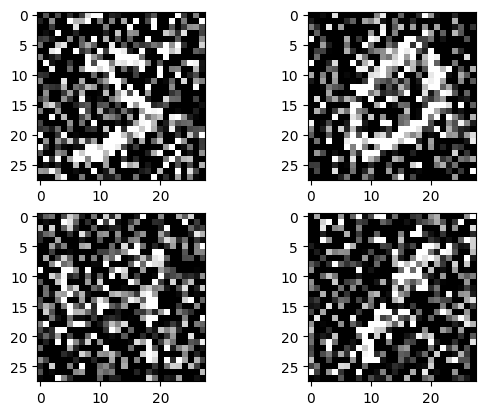

In [ ]:
# plotting noisy images
X_train_noisy, X_test_noisy = add_noise(0.6, X_train_pre, X_test_pre)
for i in range(4):
  plot_noisy(X_train_noisy[i], i)
plt.show()


Defining the autoencoder structure. The neural network has a series of convolutional layers and max pool layers to reduce the dimension (compress) the input image, thereby functioning as an encoder. The coded data is then passed through a series of convolutional and up-sampling layers to return the dimension size to that of the original image (decoder).

In an autoencoder we feed the encoder part of the neural net noisy images and keep the expected output of the neural net to be the original image. Thus, the autencoder learns to denoise a noisy image.

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

# Compression to coded data
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Encoded vector is (7, 7, 1)

# Decompression from coded data
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# making an autoencoder with an input and output layer
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# fitting the autoencoder model to noisy input images with -the actual images as expected output
autoencoder.fit(X_train_noisy, X_train_pre,
                epochs= 20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_noisy, X_test_pre))


Epoch 1/20
469/469 [==============================] - 6s 8ms/step - loss: 0.0632 - val_loss: 0.0333
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0305 - val_loss: 0.0280
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0274 - val_loss: 0.0260
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0258 - val_loss: 0.0248
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0248 - val_loss: 0.0240
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0240 - val_loss: 0.0232
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0233 - val_loss: 0.0228
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0224 - val_loss: 0.0217
Epoch 10/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0220 - val_loss: 0.0213

In [ ]:
# running the autoencoder on noisy test images
predictions = autoencoder.predict(X_test_noisy)

313/313 [==============================] - 1s 2ms/step


In [ ]:
predictions.shape

(10000, 28, 28, 1)

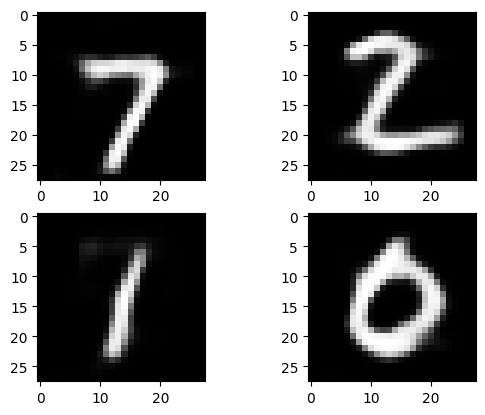

In [ ]:
# plotting the outputs of the autoencoder
for i in range(4):
  plot_noisy(predictions[i], i)
plt.show()

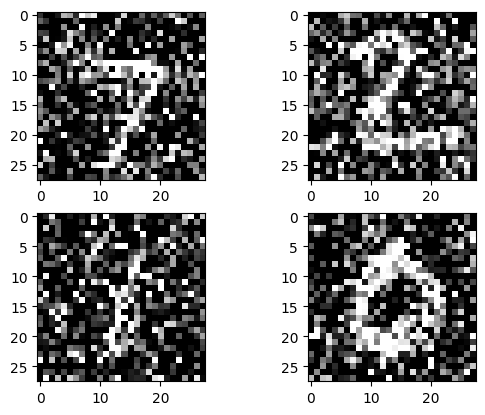

In [ ]:
# plotting the noisy input images
for i in range(4):
  plot_noisy(X_test_noisy[i], i)
plt.show()

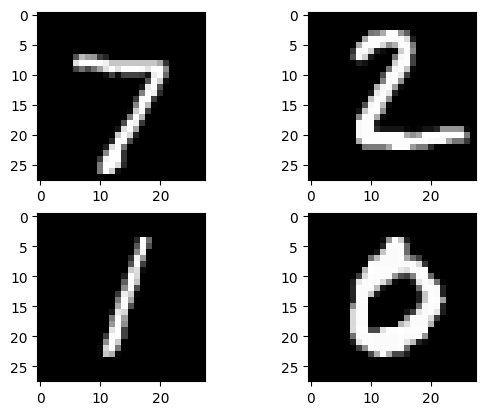

In [ ]:
# plotting the original test images
for i in range(4):
  plot_noisy(X_test[i], i)
plt.show()

Thus we see that the autoencoder performs reasonably well on the noisy MNIST dataset. It is able to denoise an image even when the noisy image is not very well perceived by humans.

## **Burst Noise Image Denoising**

Here we are working with the MNIST dataset which we shall import from keras

In [ ]:
# importing dataset
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# our training data contains 60000 28x28 images
print(X_train.shape)

(60000, 28, 28)


In [ ]:
# plotting the MNIST dataset
def plot_mnist(image, location):
  plt.subplot(221 + location)
  plt.imshow(image, cmap=plt.get_cmap('gray'))

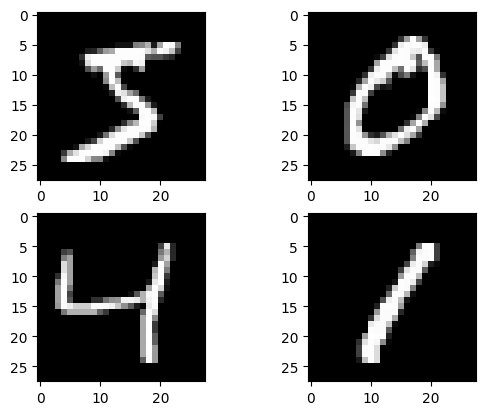

In [ ]:
for i in range(4):
  plot_mnist(X_train[i], i)
plt.show()  

Above are some of the sample images from the training dataset 

In [ ]:
def pre_processing(X_train, X_test):
  # Normalizing pixel values for neural net
  X_train = X_train.astype('float32') / 255.
  X_test = X_test.astype('float32') / 255.
  # Reshaping the image
  X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
  X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

  return X_train, X_test
  


In [ ]:
X_train_pre, X_test_pre = pre_processing(X_train, X_test)

In [ ]:
print(X_train_pre.shape)


(60000, 28, 28, 1)


In burst noise we model the noise as losing a random number of rows in the image (i.e. setting pixel valyues of random rows as zero). The number of random rows selected is determined by the noise factor.

In [ ]:
def burst_noise(noise_factor, X_train, X_test):
  # Models Burst Error
  noise_matrix = list()
  # Noise factor determines fraction of pixel rows lost
  loc = random.sample(range(28), int(28*noise_factor))
  for i in range(28):
    if(i in loc):
      noise_matrix.append([0]*28)
    else:
      noise_matrix.append([1]*28)
  noise_matrix = np.array(noise_matrix).reshape((1, 28, 28, 1))
  X_train_noisy = X_train * noise_matrix
  X_test_noisy = X_test * noise_matrix

  return X_train_noisy, X_test_noisy  

In [ ]:
def plot_noisy(image, location):
  image = image.reshape(28, 28)
  plt.subplot(221 + location)
  plt.imshow(image, cmap=plt.get_cmap('gray'))


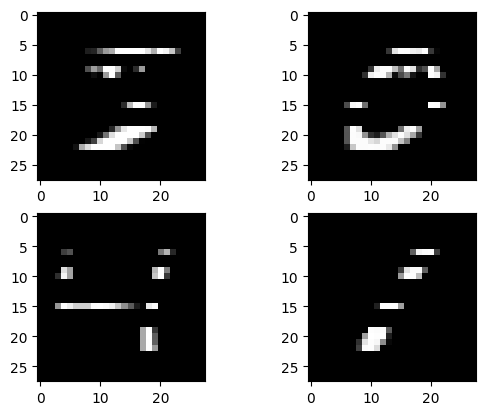

In [ ]:
# plotting noisy images
X_train_noisy, X_test_noisy = burst_noise(0.6, X_train_pre, X_test_pre)
for i in range(4):
  plot_noisy(X_train_noisy[i], i)
plt.show()


Defining the autoencoder structure. The neural network has a series of convolutional layers and max pool layers to reduce the dimension (compress) the input image, thereby functioning as an encoder. The coded data is then passed through a series of convolutional and up-sampling layers to return the dimension size to that of the original image (decoder).

In an autoencoder we feed the encoder part of the neural net noisy images and keep the expected output of the neural net to be the original image. Thus, the autencoder learns to denoise a noisy image.

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

# Compression to coded data
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Encoded vector is (7, 7, 1)

# Decompression from coded data
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# making an autoencoder with an input and output layer
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# fitting the autoencoder model to noisy input images with -the actual images as expected output
autoencoder.fit(X_train_noisy, X_train_pre,
                epochs= 20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_noisy, X_test_pre))


Epoch 1/20
469/469 [==============================] - 14s 7ms/step - loss: 0.0448 - val_loss: 0.0210
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0195 - val_loss: 0.0178
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0163 - val_loss: 0.0155
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0146 - val_loss: 0.0142
Epoch 8/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 9/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 10/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0138 - val_loss: 0.013

In [ ]:
# running the autoencoder on noisy test images
predictions = autoencoder.predict(X_test_noisy)

313/313 [==============================] - 1s 2ms/step


In [ ]:
predictions.shape

(10000, 28, 28, 1)

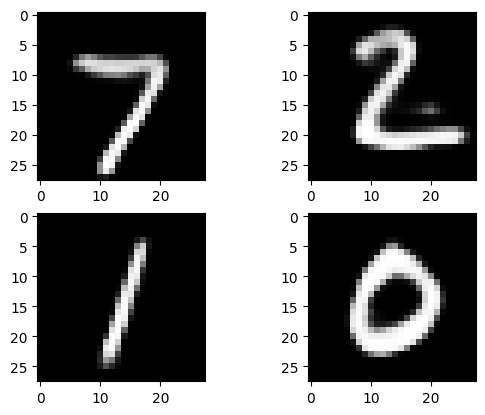

In [ ]:
# plotting the outputs of the autoencoder
for i in range(4):
  plot_noisy(predictions[i], i)
plt.show()

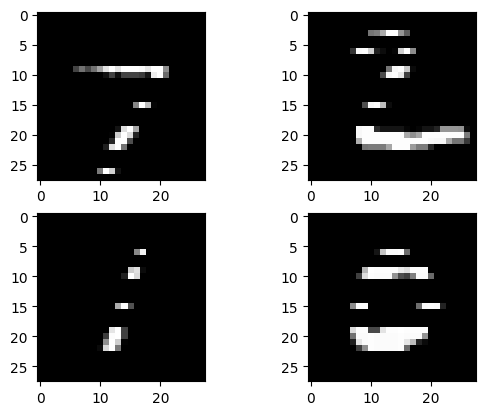

In [ ]:
# plotting the noisy input images
for i in range(4):
  plot_noisy(X_test_noisy[i], i)
plt.show()

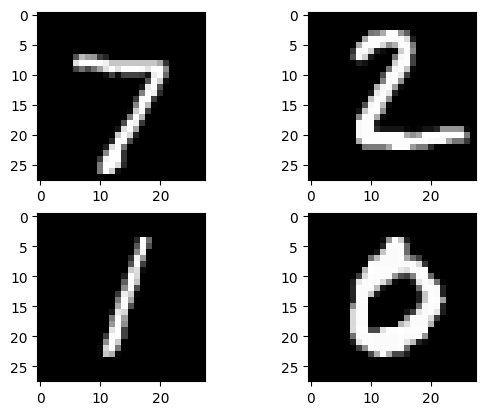

In [ ]:
# plotting the original test images
for i in range(4):
  plot_noisy(X_test[i], i)
plt.show()

Thus we see that the autoencoder performs reasonably well on the noisy MNIST dataset. It is able to denoise an image even when the noisy image is not very well perceived by humans.

## **Colorization of CIFAR-10 Images**

In [ ]:
(X_train_all, y_train_all), (X_test_all, y_test_all) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
X_train_all.shape

(50000, 32, 32, 3)

The following function gives the training and testing data for a particular class which is passed as a string in variable class_name.

In [ ]:
def get_class_data(class_name):
  classes = {"airplane" : 0, "automobile" : 1, "bird" : 2, "cat" : 3, "deer" : 4, "dog" : 5, "frog" : 6, "horse" : 7, "ship" : 8, "truck" : 9}
  class_number = classes[class_name]
  k = np.where(y_train_all==class_number)
  k = np.asarray(k) # as np.where returns a tuple
  X_train = X_train_all[k[0]]
  y_train = y_train_all[k[0]]
  k = np.where(y_test_all==class_number)
  k = np.asarray(k) 
  X_test = X_test_all[k[0]]
  y_test = y_test_all[k[0]]
  return X_train,y_train,X_test,y_test

We will be training our model on images of horse.

In [ ]:
X_train,y_train,X_test,y_test = get_class_data('horse')

In [ ]:
def plot_img(image, location):
  plt.subplot(221 + location)
  plt.imshow(image)

Some sample actual images.


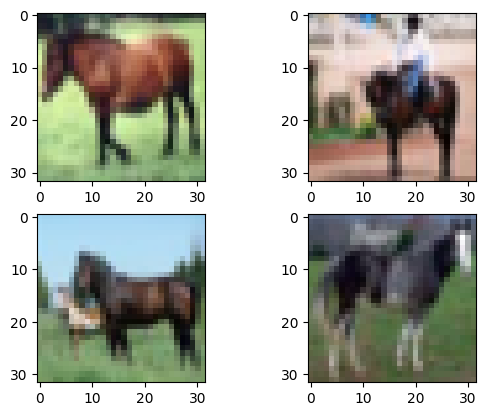

In [ ]:
print("Some sample actual images.")
for i in range(4):
  plot_img(X_train[i], i)
plt.show()

In [ ]:
X_train.shape

(5000, 32, 32, 3)

Now, we shall preprocess the data so that all the pixel intensity values are between 0 and 1.

Care has been taken regarding the dimensions of data in the form of numpy array being fed to neural network.

In [ ]:
def pre_processing(X_train, X_test):
  # Normalizing pixel values for neural net
  X_train = X_train.astype('float32') / 255.
  X_test = X_test.astype('float32') / 255.
  X_train = np.reshape(X_train, (len(X_train), 32, 32, 3))
  X_test = np.reshape(X_test, (len(X_test), 32, 32, 3))

  return X_train, X_test

In [ ]:
X_train_pre, X_test_pre = pre_processing(X_train, X_test)

In [ ]:
## gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
X_train_bw = np.dot(X_train_pre[...,:3], [0.299, 0.587, 0.114])  
# this carries out a dot product between rgb values in X_train_pre and the given vector which converts rgb pixel values to grayscale
X_train_bw = np.reshape(X_train_bw,(len(X_train_bw),32,32,1))
X_test_bw = np.dot(X_test_pre[...,:3], [0.299, 0.587, 0.114])    
# this carries out a dot product between rgb values in X_test_pre and the given vector which converts rgb pixel values to grayscale
X_test_bw = np.reshape(X_test_bw,(len(X_test_bw),32,32,1))

In [ ]:
X_train_bw.shape

(5000, 32, 32, 1)

In [ ]:
X_test_pre.shape

(1000, 32, 32, 3)

In [ ]:
def plot_img_bw(image, location): # function to display grayscale images
  plt.subplot(221 + location)
  plt.imshow(image, cmap=plt.get_cmap('gray'))

Grayscale image samples that would begiven as input while training.


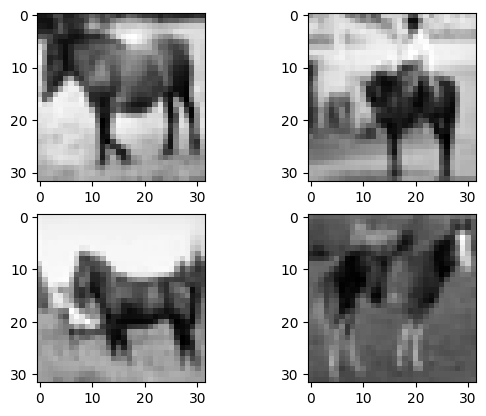

In [ ]:
print("Grayscale image samples that would begiven as input while training.")
for i in range(4):
  plot_img_bw(X_train_bw[i], i)
plt.show()

Defining the autoencoder structure. The neural network has a series of convolutional layers and max pool layers to reduce the dimension (compress) the input image, thereby functioning as an encoder. The coded data is then passed through a series of convolutional and up-sampling layers to return the dimension size to that of the original image (decoder).

In an autoencoder we feed the encoder part of the neural net black-and-white images and keep the expected output of the neural net to be the original image. Thus, the autencoder learns to colorize an image.

In [ ]:
input_img = keras.Input(shape=(32, 32, 1))

x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Encoded data is (8, 8, 64)

x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(encoded)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(X_train_bw, X_train_pre,
                epochs= 30,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_bw, X_test_pre))


Epoch 1/30
40/40 [==============================] - 13s 35ms/step - loss: 0.0423 - val_loss: 0.0276
Epoch 2/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0223 - val_loss: 0.0190
Epoch 3/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0171 - val_loss: 0.0156
Epoch 4/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 5/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 6/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 7/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 8/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 9/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0109 - val_loss: 0.0116
Epoch 10/30
40/40 [==============================] - 1s 15ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 11

As we are done with training, we shall now move on to colorize grayscale images of horses.

In [ ]:
predictions = autoencoder.predict(X_test_bw)

32/32 [==============================] - 0s 2ms/step


In [ ]:
predictions.shape

(1000, 32, 32, 3)

Grayscale image given as input to model.


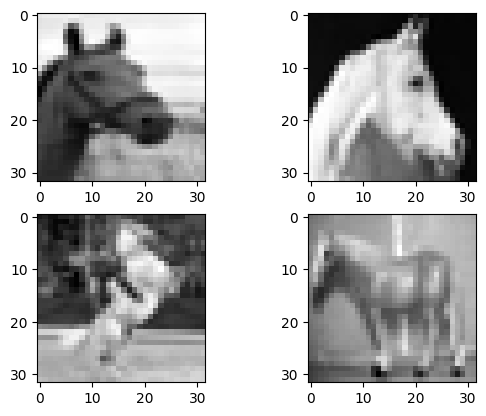

In [ ]:
print("Grayscale image given as input to model.")
for i in range(4):
  plot_img_bw(X_test_bw[i+10], i)
plt.show()

Colorized images. 


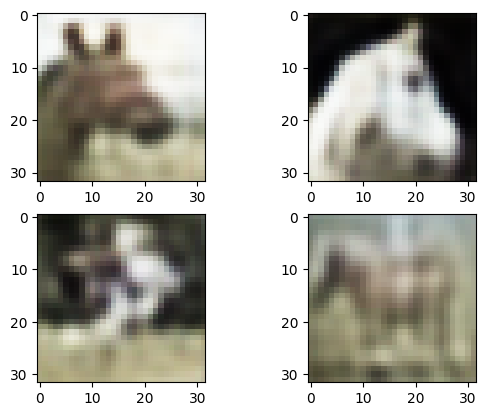

In [ ]:
print("Colorized images. ")
for i in range(4):
  plot_img(predictions[i+10], i)
plt.show()

In the images above, we can see that our model correctly identifies pixels belonging to horse. It generally gives background at the bottom in greenish color as most of the images have horses on grass while sky is in the background at top.

Actual colored images.


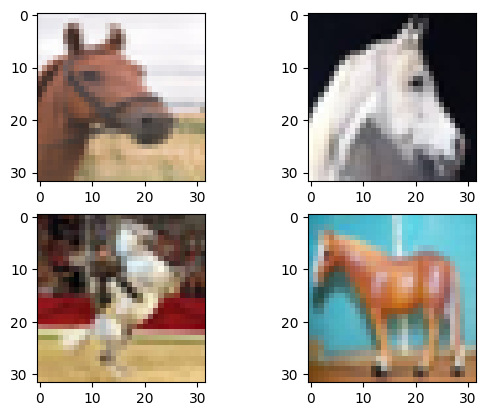

In [ ]:
print("Actual colored images.")
for i in range(4):
  plot_img(X_test_pre[i+10], i)
plt.show()

The following is just for checking some outputs on the training data to see how well has our model learnt the data that it has trained on.

157/157 [==============================] - 0s 3ms/step
Grayscale image given as input to model.


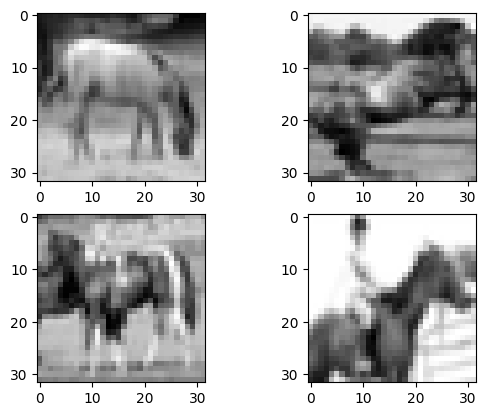

Colorized images 


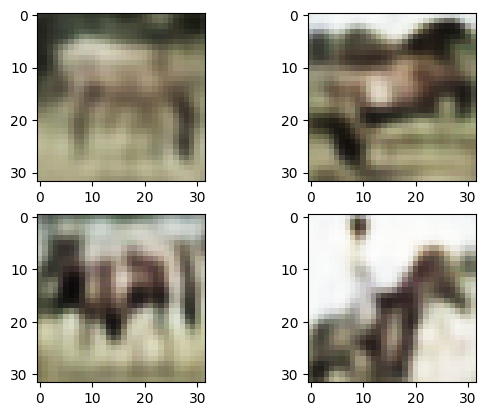

Actual colored images.


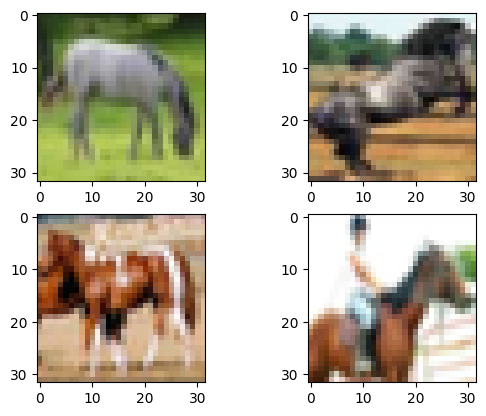

In [ ]:
predictions = autoencoder.predict(X_train_bw)
print("Grayscale image given as input to model.")
for i in range(4):
  plot_img_bw(X_train_bw[i+10], i)
plt.show()
print("Colorized images ")
for i in range(4):
  plot_img(predictions[i+10], i)
plt.show()
print("Actual colored images.")
for i in range(4):
  plot_img(X_train_pre[i+10], i)
plt.show()

Now we would like to check how does our model works on images of other classes which it was not trained on.

In [ ]:
def colorize_other_class (class_name):  # this function takes class_name as input
 X_class,d1,d2,d3 = get_class_data(class_name) # d1,d2,d3 are just temporary dummy variables
 X_class_pre,d1_pre = pre_processing(X_class, d2) # preprocessing the new data on new class
 X_class_bw = np.dot(X_class_pre[...,:3], [0.299, 0.587, 0.114]) # converting rgb to grayscale
 X_class_bw = np.reshape(X_class_bw,(len(X_class_bw),32,32,1)) # getting the dimensions of the data as required by the autoencoder

 predictions = autoencoder.predict(X_class_bw)
 print("Grayscale Images")
 for i in range(4):
   plot_img_bw(X_class_bw[i+20], i)  # to plot few grayscale images.
 plt.show()

 print("Colorized Images")
 for i in range(4):
   plot_img(predictions[i+20], i)    # to plot their corresponding predictions
 plt.show()

 print("Actual images")
 for i in range(4):
   plot_img(X_class_pre[i+20], i)    # to plot actual color image to compare it with colorized image 
 plt.show()

 return

157/157 [==============================] - 0s 3ms/step
Grayscale Images


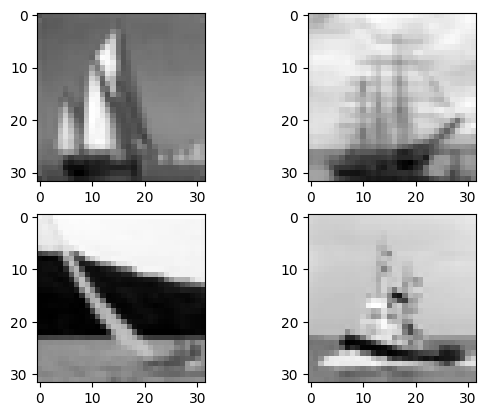

Colorized Images


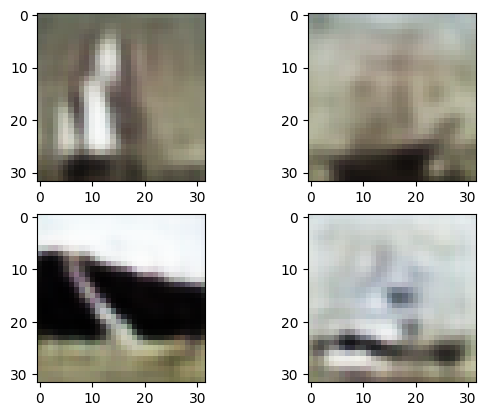

Actual images


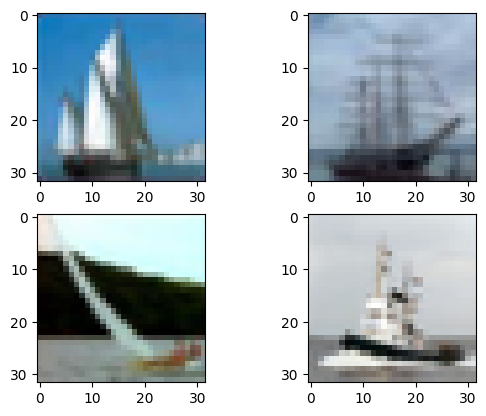

In [ ]:
colorize_other_class('ship')

In the images above, we can see that our model gives greenish colour to the water containing region. It gives brownish color, the one it gave to horses as well. However, it properly colorizes the sky. Therefore, we can see that a limitation of autoencoders is that it is class specific.

In the cells below, we can see the similar effects for other classes.

157/157 [==============================] - 0s 2ms/step
Grayscale Images


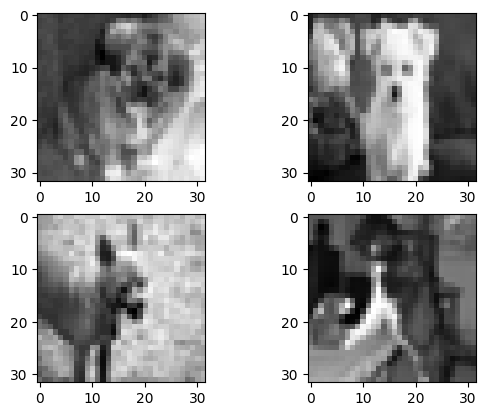

Colorized Images


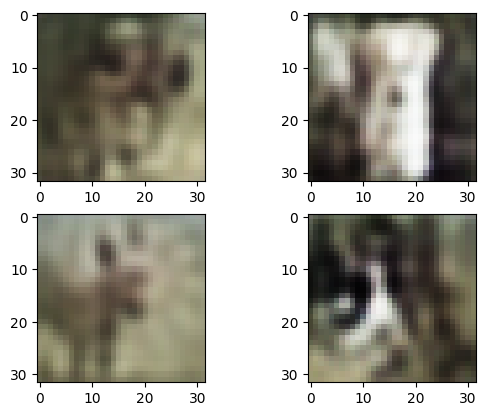

Actual images


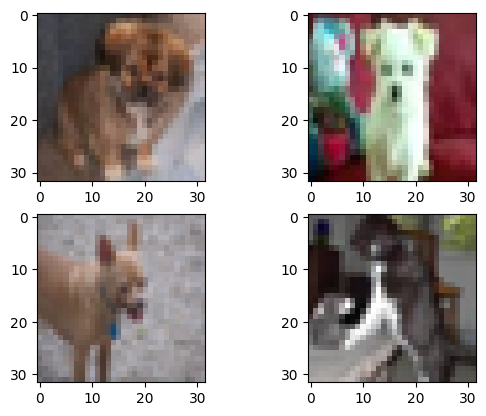

In [ ]:
colorize_other_class('dog')

157/157 [==============================] - 0s 2ms/step
Grayscale Images


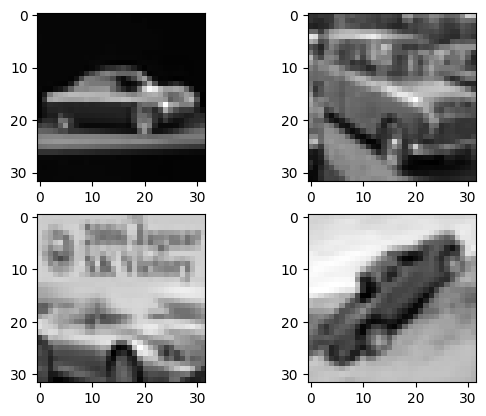

Colorized Images


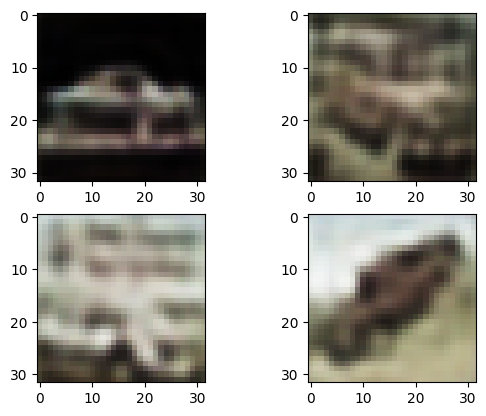

Actual images


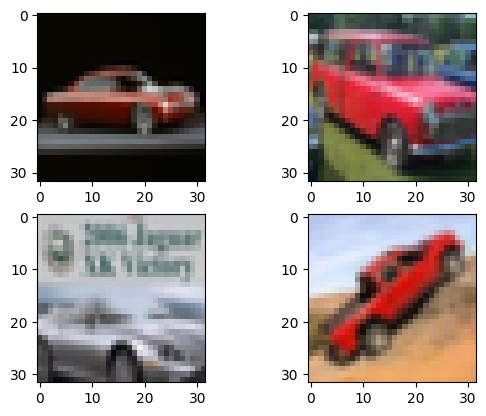

In [ ]:
colorize_other_class('automobile')

157/157 [==============================] - 0s 3ms/step
Grayscale Images


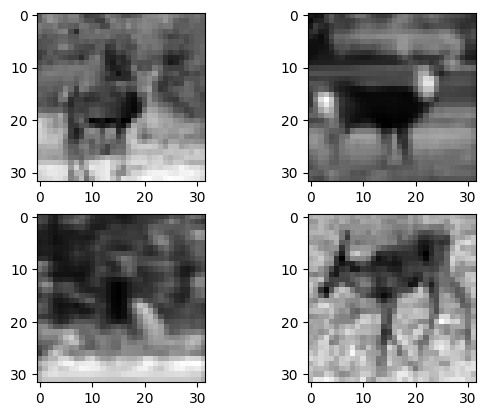

Colorized Images


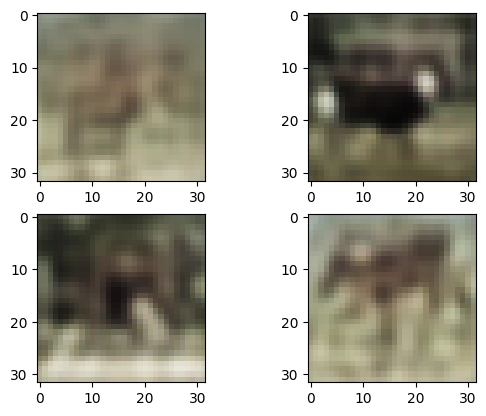

Actual images


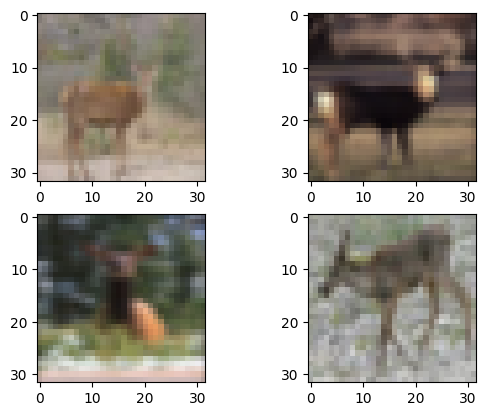

In [ ]:
colorize_other_class('deer')

157/157 [==============================] - 1s 3ms/step
Grayscale Images


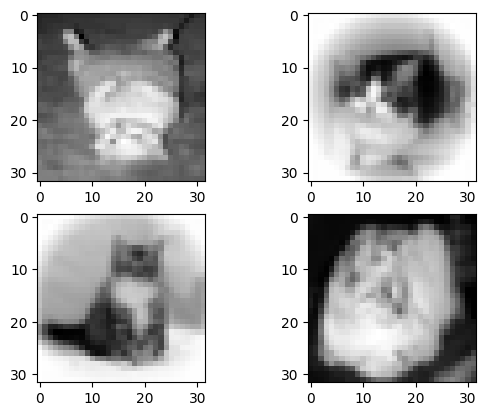

Colorized Images


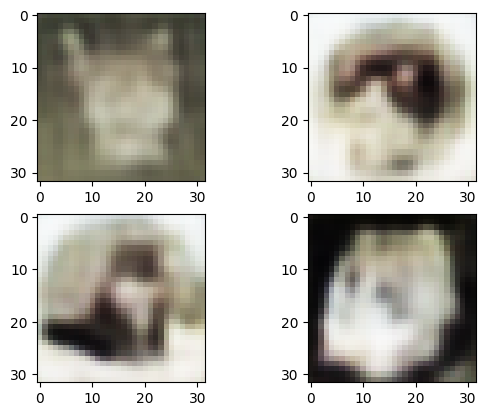

Actual images


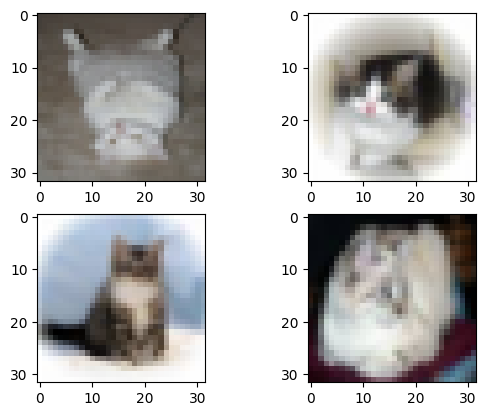

In [ ]:
colorize_other_class('cat')

## **Colorization of Intel Images**

The datasets used above are of somewhat low resolution. We also wanted to try our autoencoder model on images of larger resolution. 

First, let us download the [Intel Image dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), which consists of $150\times150$ resolution images. We download the zip file from a personal Google drive, and unzip data

In [ ]:
# Downloading zip file from personal drive
!gdown --id 1asM0Iogdcu1Fi58pAq97J9x8zTSj8J2a

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1asM0Iogdcu1Fi58pAq97J9x8zTSj8J2a
To: /content/intel_data.zip
100% 254M/254M [00:01<00:00, 188MB/s]


In [ ]:
# Unzipping data
!unzip intel_data.zip

Extracting training and testing data. Note that the directory structure is similar to that used in Assignment 2, so we rework that code to serve our purposes here.

In [ ]:
data_dir = 'intel_data'
# Extracting training and testing (here, called validation) data from directory
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x)) for x in ['train', 'val']}

Forming training and testing data arrays for a particular class number, since autoencoders are class specific. We also drop those images that are not of $150\times150$ resolution, so as to retain uniformity.

In [ ]:
# Class number to train autoencoder on
class_no = 3
# Forming Training and Testing data
X_train = list()
train_count = 0
test_count = 0
X_test = list()
# Storing training data
for i in range(len(image_datasets['train'])):
  # Storing only those images that are 150x150 and belong to required class
  if(np.shape(np.asarray(image_datasets['train'][i][0])) == (150, 150, 3) and image_datasets['train'][i][1] == class_no):
    X_train.append(np.asarray(image_datasets['train'][i][0]))
    train_count += 1
# Storing testing data
for i in range(len(image_datasets['val'])):
  # Storing only those images that are 150x150 and belong to required class
  if(np.shape(np.asarray(image_datasets['val'][i][0])) == (150, 150, 3)  and image_datasets['val'][i][1] == class_no):
    X_test.append(np.asarray(image_datasets['val'][i][0]))
    test_count += 1
# Reshaping data into required format
X_train = np.array(X_train).reshape(train_count, 150, 150, 3)
X_test = np.array(X_test).reshape(test_count, 150, 150, 3)

In [ ]:
# Shape of a single 150x150 color (RGB) image
np.shape(X_train[0])

(150, 150, 3)

Let us have a look at some of the training images for the class being accessed.

In [ ]:
def plot_img(image, location):
  plt.subplot(221 + location)
  plt.imshow(image)

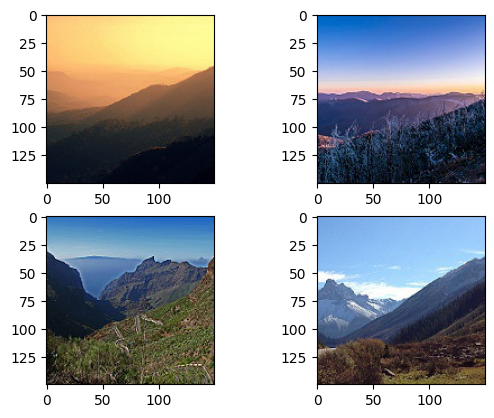

In [ ]:
for i in range(4):
  plot_img(X_train[i], i)
plt.show()

Defining a preprocessing function, since neural networks perform better when data is normalized.

In [ ]:
def pre_processing(X_train, X_test):
  # Normalizing pixel values for neural net
  X_train = X_train.astype('float32') / 255.
  X_test = X_test.astype('float32') / 255.
  X_train = np.reshape(X_train, (len(X_train), 150, 150, 3))
  X_test = np.reshape(X_test, (len(X_test), 150, 150, 3))

  return X_train, X_test

In [ ]:
X_train_pre, X_test_pre = pre_processing(X_train, X_test)

We also define arrays to store images in a black-and-white format, using the formula specified. These will be used as inputs to our image colourization autoencoder.

In [ ]:
# gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
X_train_bw = np.dot(X_train_pre[...,:3], [0.299, 0.587, 0.114])
X_train_bw = np.reshape(X_train_bw,(len(X_train_bw),150,150,1))
X_test_bw = np.dot(X_test_pre[...,:3], [0.299, 0.587, 0.114])
X_test_bw = np.reshape(X_test_bw,(len(X_test_bw),150,150,1))

In [ ]:
X_train_bw.shape

(2495, 150, 150, 1)

In [ ]:
X_test_pre.shape

(523, 150, 150, 3)

Let us have a look at some of the training images after being converted to black-and-white.

In [ ]:
def plot_img_bw(image, location):
  plt.subplot(221 + location)
  plt.imshow(image, cmap=plt.get_cmap('gray'))

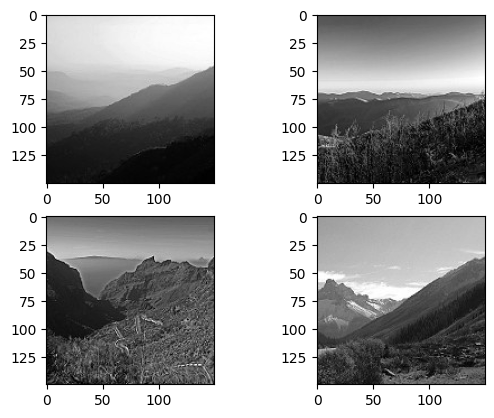

In [ ]:
for i in range(4):
  plot_img_bw(X_train_bw[i], i)
plt.show()

Defining the autoencoder structure. The neural network has a series of convolutional layers and max pool layers to reduce the dimension (compress) the input image, thereby functioning as an encoder. The coded data is then passed through a series of convolutional and up-sampling layers to return the dimension size to that of the original image (decoder).  

During training, the autoencoder is given black-and-white images as input and compares the output with the true color image.

In [ ]:
input_img = keras.Input(shape=(150, 150, 1))

# Compression to coded data
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((3, 3), padding='same')(x)
encoded = layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

# Encoded data is (25, 25, 1)

# Decompression from coded data
x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(encoded)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((3, 3))(x)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Training autoencoder on black-and-white images and comparing with true color images
autoencoder.fit(X_train_bw, X_train_pre,
                epochs= 30,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_bw, X_test_pre))


Epoch 1/30
20/20 [==============================] - 18s 456ms/step - loss: 0.0656 - val_loss: 0.0480
Epoch 2/30
20/20 [==============================] - 4s 214ms/step - loss: 0.0404 - val_loss: 0.0330
Epoch 3/30
20/20 [==============================] - 4s 221ms/step - loss: 0.0274 - val_loss: 0.0237
Epoch 4/30
20/20 [==============================] - 4s 214ms/step - loss: 0.0204 - val_loss: 0.0187
Epoch 5/30
20/20 [==============================] - 4s 215ms/step - loss: 0.0179 - val_loss: 0.0176
Epoch 6/30
20/20 [==============================] - 4s 221ms/step - loss: 0.0173 - val_loss: 0.0164
Epoch 7/30
20/20 [==============================] - 4s 216ms/step - loss: 0.0161 - val_loss: 0.0185
Epoch 8/30
20/20 [==============================] - 4s 222ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 9/30
20/20 [==============================] - 4s 222ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 10/30
20/20 [==============================] - 4s 216ms/step - loss: 0.0152 - val_loss: 0.015

In [ ]:
# Running the autoencoder with black-and-white testing images
predictions = autoencoder.predict(X_test_bw)

17/17 [==============================] - 1s 15ms/step


In [ ]:
predictions.shape

(523, 150, 150, 3)

We can now see the black-and-white images, the autoencoder colored output, and the true color images.

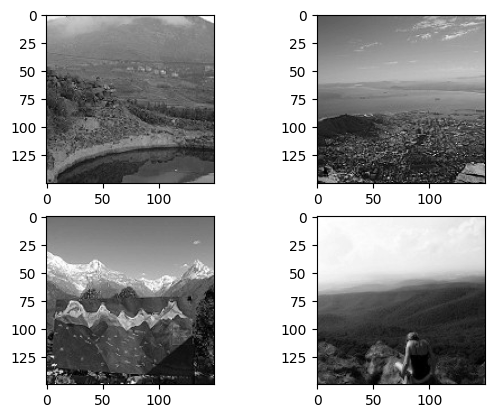

In [ ]:
# Black-and-white images
for i in range(4):
  plot_img_bw(X_test_bw[i], i)
plt.show()

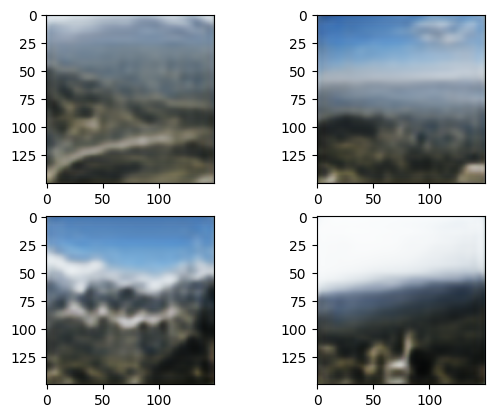

In [ ]:
# Predicted color images
for i in range(4):
  plot_img(predictions[i], i)
plt.show()

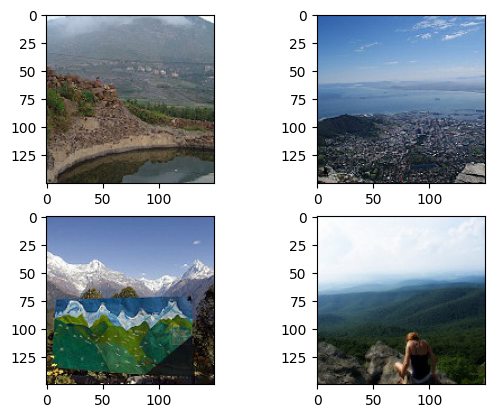

In [ ]:
# True color images
for i in range(4):
  plot_img(X_test_pre[i], i)
plt.show()

We can see that the autoencoder performs reasonably well in the colorization task. In the case of mountain images, it has been able to learn the general color of the terrain, as well as that of the sky and clouds.